In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output

In [ ]:
import torch
from torch import nn
from torch.nn import functional
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchvision import datasets, transforms, utils
import torch.optim as optim

In [ ]:
from collections import defaultdict
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data Preparation

In [ ]:
ZIP_PATH = 'archive'
DATA_PATH = 'images'

In [ ]:
%%time
! unzip $ZIP_PATH -d $DATA_PATH

To train a GAN, very large datasets are needed. Let's increase the volume of input data using augmentations. Initially, we will only use modifications to input images that are permissible in generated images as well. For example, mirror reflection and color changes. Additionally, we will reduce the size to prevent overfitting of the discriminator.

In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ColorJitter(saturation=1, hue=0.5),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
dataset = datasets.ImageFolder('images/images', transform=transform)

In [ ]:
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Let's visualize several images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


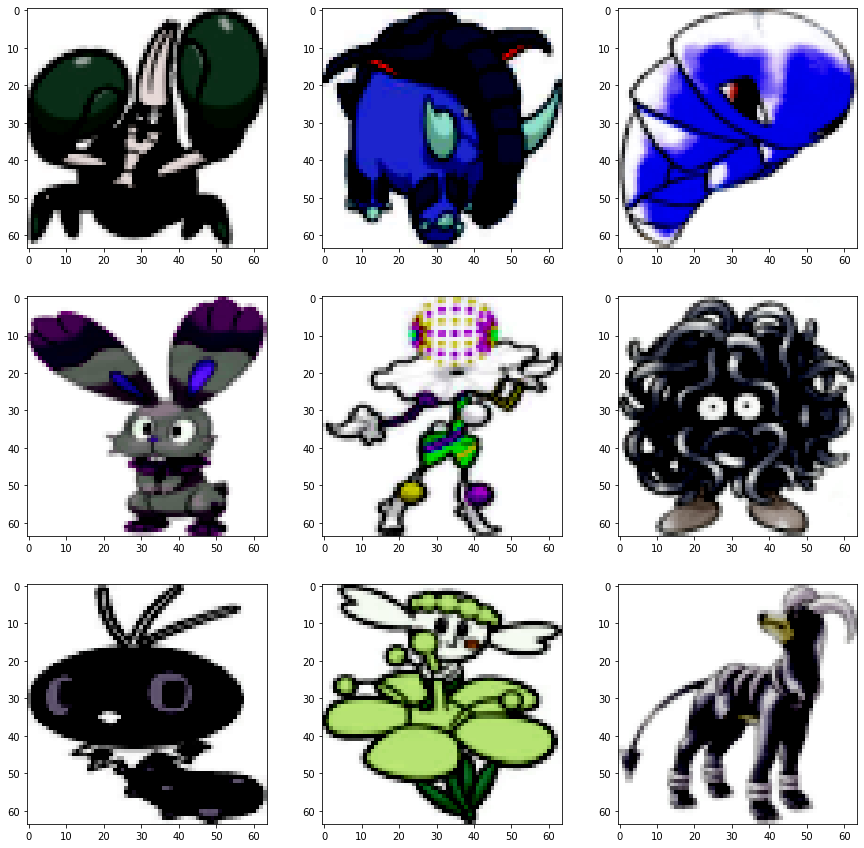

In [ ]:
images, labels = next(iter(dataloader))

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
  for j in range(3):
    ax[i][j].imshow(np.transpose(images[3*i + j], (1, 2, 0)))

# Baseline

First model consists of convolutional generator and discriminator

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # 3 x 64 x 64

        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

Random initialization of weights

In [ ]:
def random_weights_init(net):
  classname = net.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(net.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(net.weight.data, 1.0, 0.02)
    nn.init.constant_(net.bias.data, 0)

Create a discriminator and a generator that takes latent vectors of length 100 as input.

In [ ]:
discr_net = Discriminator().to(device)
gen_net = Generator(100).to(device)
discr_net.apply(random_weights_init)
gen_net.apply(random_weights_init)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


Preliminary runs indicated that the discriminator quickly overfits when the same learning rate is used for both models. Therefore, a smaller learning rate was chosen for the discriminator.

In [ ]:
criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

## Training

In [ ]:
def train(
    discr_model, 
    gen_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None
):
    '''
    Training pipeline

    :param discr_model: discriminator
    :param gen_model: generator
    :param criterion: loss function
    :param discr_optim: discriminator optimizer
    :param discr_gen: generator optimizer
    :param dataloder: train dataloader
    :param num_epochs: number of epochs
    :fixed_vectors: fixed noise for visualization

    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []

    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)

        # Train discriminator on real Pokemons
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Train discriminator on generated images
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Train generator
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())
        

      # Visualization
      clear_output(wait=True)

      # Print results after each epoch
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15) #loss
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15) #loss
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15) #averaged discriminator scores
      plt.plot(true_images_score, label='на реальных изображениях') #on real images
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')#on fake images (before update)
      plt.plot(gen_score, label='на сгенерированных изображениях 2')#on fake images (after update)
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.show()
      
      #Save generator outputs on the fixed noise
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

Epoch 30 of 30 took 12.559s


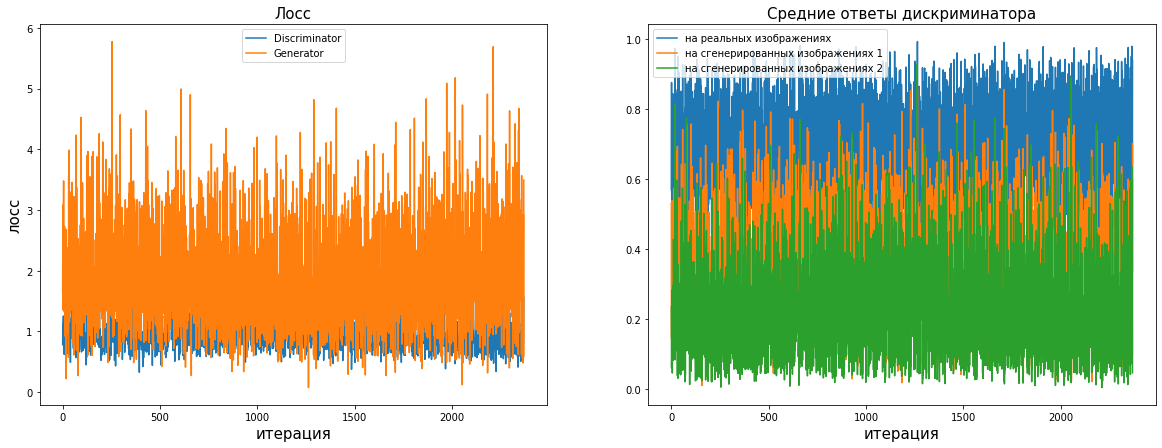

In [ ]:
discr_net, gen_net, examples = train(discr_net, 
                                     gen_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Let's look at several samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


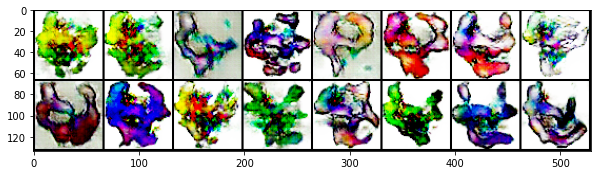

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[20], (1, 2, 0)))

Let's try to improve the model's quality and make it more challenging for the discriminator to overfit.

# Attention layers

Add a self-attention layer to both models, allowing control over distant regions of the image and maintaining consistency.

In [ ]:
class Attention(nn.Module):
  def __init__(self, D_in):
    super().__init__()

    self.key = nn.Conv2d(D_in, D_in // 4, 1)
    self.query = nn.Conv2d(D_in, D_in // 4, 1)
    self.value = nn.Conv2d(D_in, D_in, 1)
    self.softmax = nn.Softmax(-1)

    #trainable parameter that determines the weight for attention
    self.coef = nn.Parameter(torch.zeros(1))

  def forward(self, input):
    size_of_batch, channels, w, h = input.size()

    keys = self.key(input).view(size_of_batch, -1, w * h)
    queries = self.query(input).view(size_of_batch, -1, w * h)
    values = self.value(input).view(size_of_batch, -1, w * h)

    attention = self.softmax(torch.bmm(queries.permute(0, 2, 1), keys))
    output = torch.bmm(values, attention.permute(0, 2, 1))
    output = self.coef * output.view(size_of_batch, channels, w, h) + input

    return output

In [ ]:
class Generator_with_attention(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator_with_attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # 3 x 64 x 64

        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        Attention(256),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
discr_with_attention_net = Discriminator_with_attention().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_with_attention_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_with_attention_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 16.255s


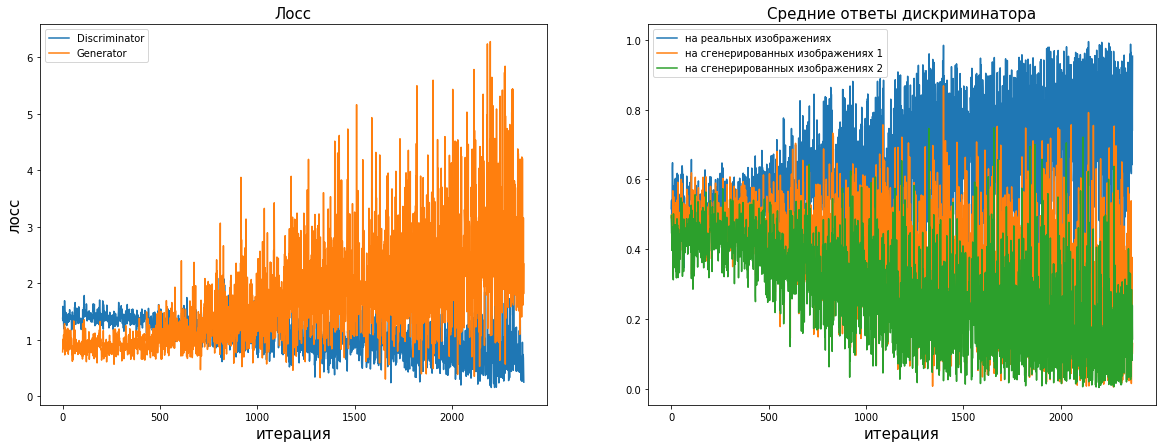

In [ ]:
discr_with_attention_net, gen_with_attention_net, examples = train(
                                     discr_with_attention_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


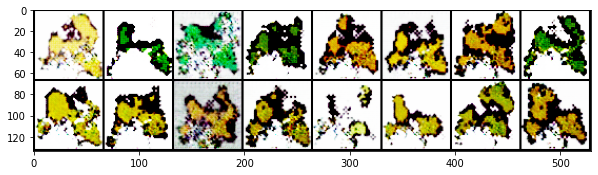

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

It is evident that the discriminator is overfitting more quickly, as the addition of attention has increased the number of trainable parameters and complicated the model. Let's try using the old discriminator and generator with attention instead.

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 15.577s


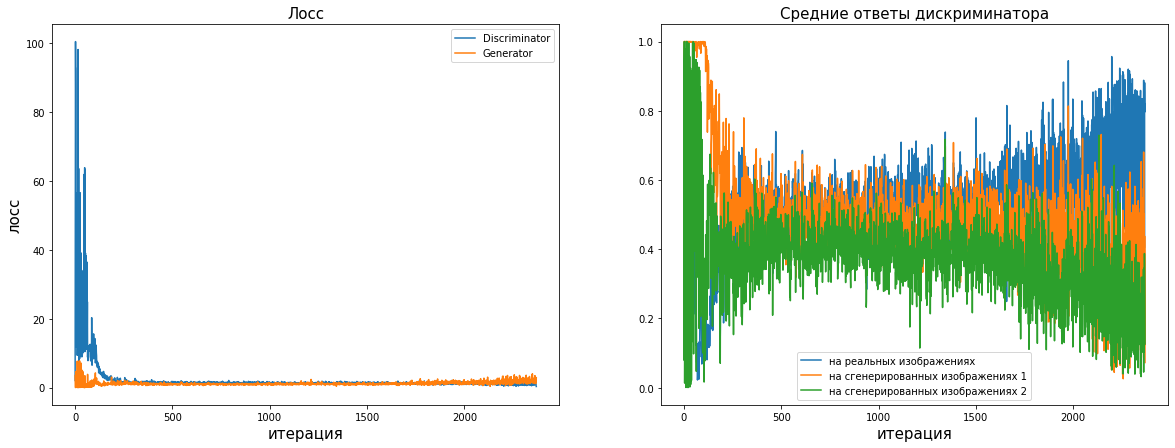

In [ ]:
discr_net, gen_with_attention_net, examples = train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


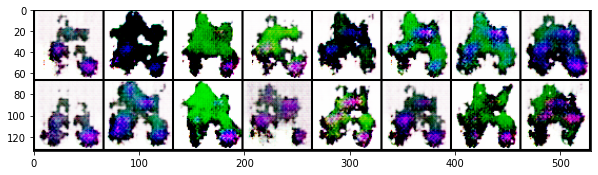

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[20], (1, 2, 0)))

Now overfitting starts later, but the problem has not been completely resolved.

## Mitigation of discriminator overfitting

To further complicate the task for the discriminator, let's add noise to the labels.

In [ ]:
def smart_train(
    discr_model, 
    gen_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None,
    adjust_lr=False
):
    '''
    Training pipeline

    :param discr_model: discriminator
    :param gen_model: generator
    :param criterion: loss function
    :param discr_optim: discriminator optimizer
    :param discr_gen: generator optimizer
    :param dataloder: train dataloader
    :param num_epochs: number of epochs
    :fixed_vectors: fixed noise for visualization
    :adjust_lr: if True learning rate will be adjusted during training
    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []
    num_batches = len(dataloader)


    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)

        # Train discriminator on real images
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device) 
        labels -= torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Train discriminator on fake images
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        labels += torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Train generator
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())

      if adjust_lr and epoch > 0:
        true_score = np.mean(true_images_score[-num_batches:])
        fake_score = np.mean(gen_score[-num_batches:])
        if true_score - fake_score > 0.4:
            discr_optim.param_groups[0]['lr'] *= 0.9

      # Visualize
      clear_output(wait=True)

      
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15) #loss
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15) #loss
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15) #averaged discriminator scores
      plt.plot(true_images_score, label='на реальных изображениях') #on real images
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')#on fake images (before update)
      plt.plot(gen_score, label='на сгенерированных изображениях 2')#on fake images (after update)
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.show()
      
      #Save generator outputs on the fixed noise
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

Let's test our new train function on the model without attention

In [ ]:
discr_net = Discriminator().to(device)
gen_net = Generator(100).to(device)
discr_net.apply(random_weights_init)
gen_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 12.044s


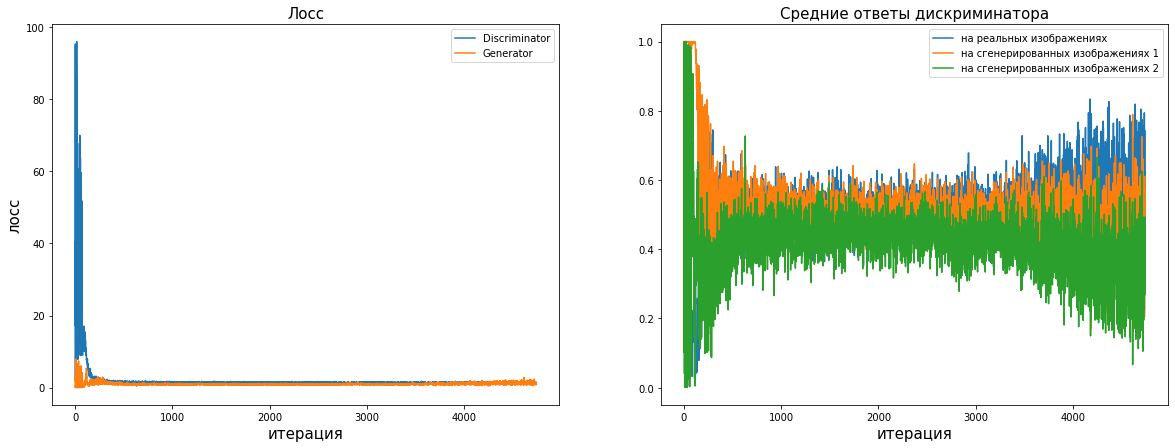

In [ ]:
discr_net, gen_net, examples = smart_train(
                                     discr_net, 
                                     gen_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Visualize samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


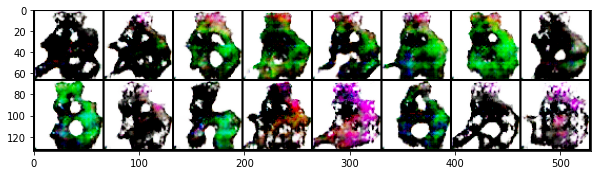

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


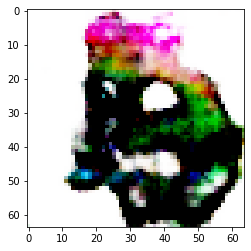

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.rand(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


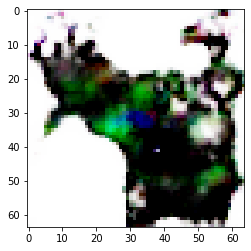

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


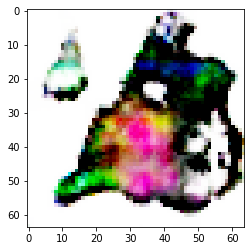

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


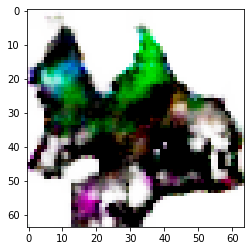

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

The generated images already resemble creatures. Can we improve the quality by incorporating attention?

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
discr_net.apply(random_weights_init)
gen_with_attention_net.apply(random_weights_init)

criterion = functional.binary_cross_entropy

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

fixed_vectors = torch.randn(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 15.472s


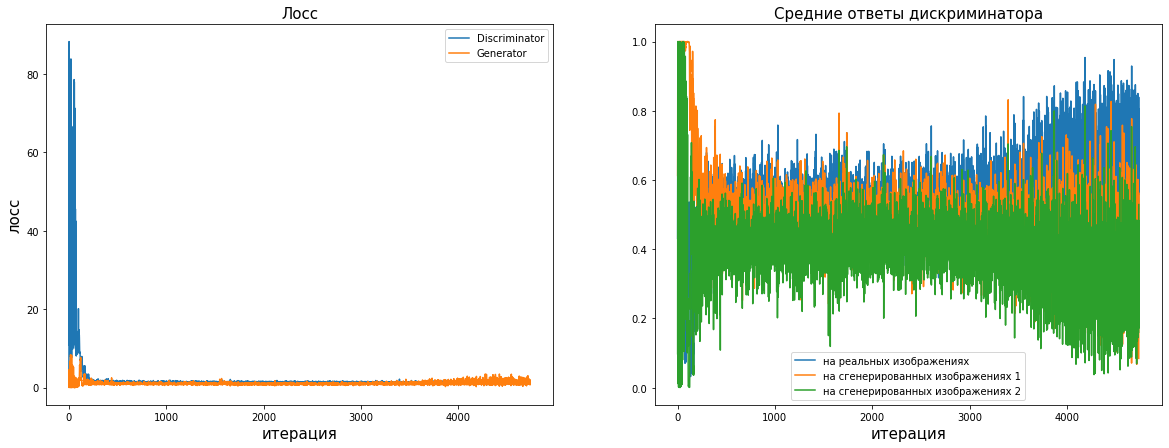

In [ ]:
discr_net, gen_with_attention_net, examples = smart_train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


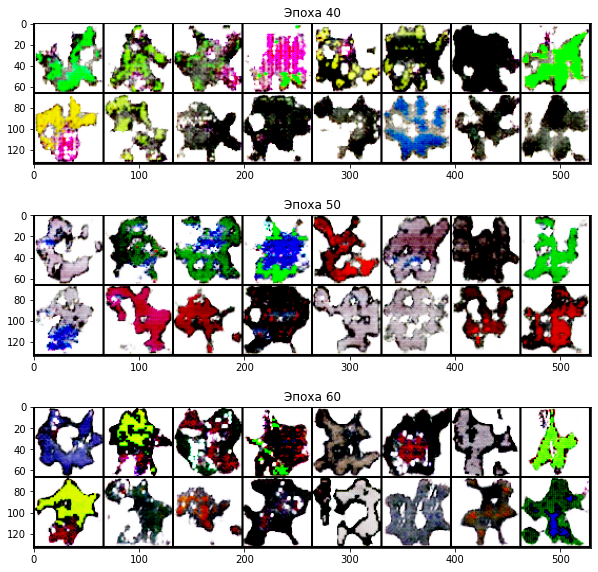

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(np.transpose(examples[39], (1, 2, 0)))
plt.title('Эпоха 40')
plt.subplot(3, 1, 2)
plt.imshow(np.transpose(examples[49], (1, 2, 0)))
plt.title('Эпоха 50')
plt.subplot(3, 1, 3)
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))
plt.title('Эпоха 60');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


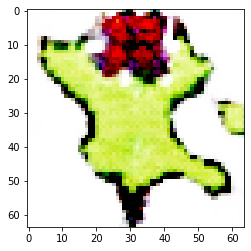

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


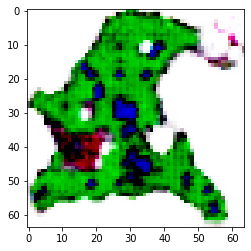

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


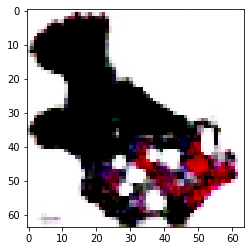

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_with_attention_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


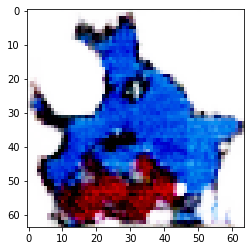

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


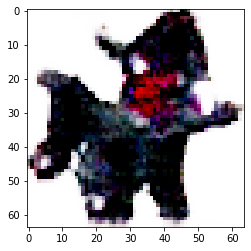

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

In [ ]:
# torch.save(discr_net.state_dict(), 'discr_net')
# torch.save(gen_with_attention_net.state_dict(), 'gen_with_attention_net')

Although the responses to real and fake images already differ, the discriminator still occasionally makes mistakes, indicating that the model can be further trained for a few more epochs.

Epoch 30 of 30 took 15.521s


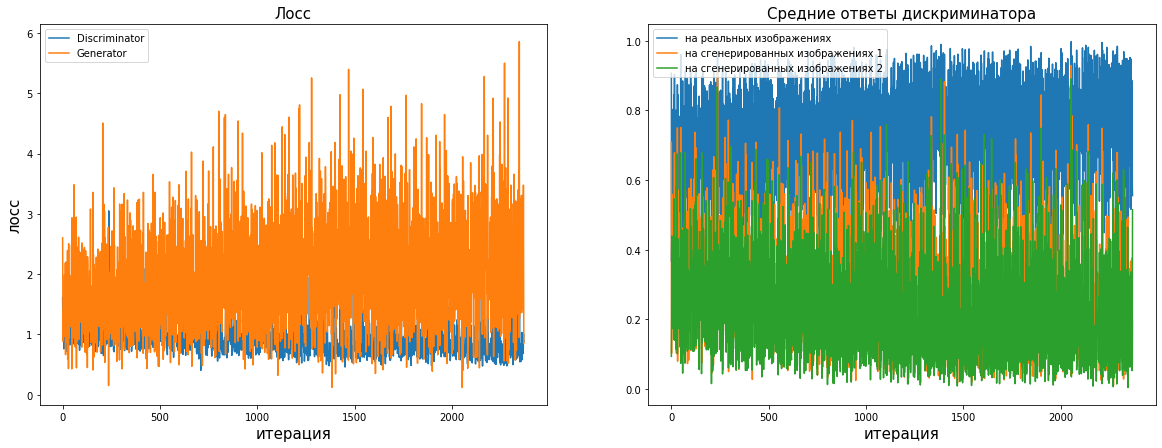

In [ ]:
discr_net.load_state_dict(torch.load('discr_net'))
gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

discr_net, gen_with_attention_net, examples = smart_train(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


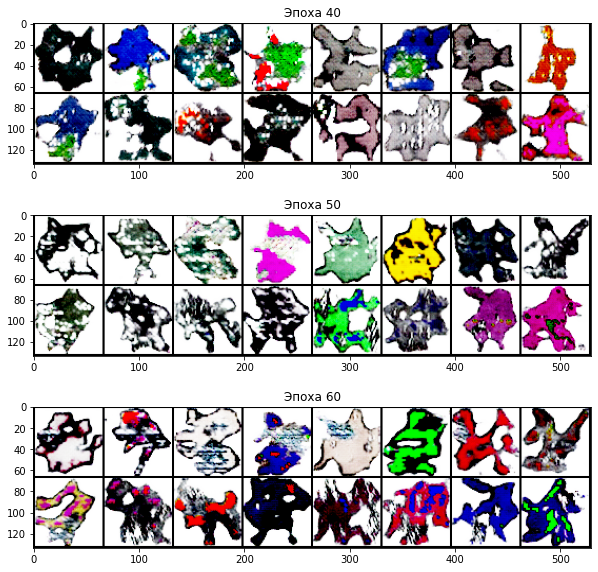

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(np.transpose(examples[0], (1, 2, 0)))
plt.title('Эпоха 40')
plt.subplot(3, 1, 2)
plt.imshow(np.transpose(examples[19], (1, 2, 0)))
plt.title('Эпоха 50')
plt.subplot(3, 1, 3)
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))
plt.title('Эпоха 60');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


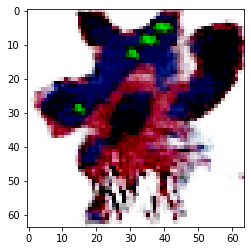

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

As expected, adding attention helps maintain the integrity of the image. Now, each entity has its own set of colors and is more homogeneous.

# Nonleaking augmentations

Increasing the size of the input dataset can be achieved by adding augmentations. However, some augmentations are undesirable in generated images. To prevent leakage of augmentations, they should be applied during model training, before each discriminator call. We will use several augmentations implemented in lucidrains/stylegan2-pytorch.

In [ ]:
from functools import partial

def DiffAugment(x, types=[]):
    for p in types:
        for f in AUGMENT_FNS[p]:
            x = f(x)
    return x.contiguous()

def rand_brightness(x, scale):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5) * scale
    return x

def rand_contrast(x, scale):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (((torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5) * 2.0 * scale) + 1.0) + x_mean
    return x

def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = functional.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x

def rand_offset(x, ratio=1, ratio_h=1, ratio_v=1):
    w, h = x.size(2), x.size(3)

    imgs = []
    for img in x.unbind(dim = 0):
        max_h = int(w * ratio * ratio_h)
        max_v = int(h * ratio * ratio_v)

        value_h = random.randint(0, max_h) * 2 - max_h
        value_v = random.randint(0, max_v) * 2 - max_v

        if abs(value_h) > 0:
            img = torch.roll(img, value_h, 2)

        if abs(value_v) > 0:
            img = torch.roll(img, value_v, 1)

        imgs.append(img)

    return torch.stack(imgs)

AUGMENT_FNS = {
    'brightness': [partial(rand_brightness, scale=1.)],
    'contrast':  [partial(rand_contrast, scale=.5)],
    'offset': [rand_offset],
    'translation': [rand_translation],
}

In [ ]:
class Augment(nn.Module):
  def __init__(self, image_size):
    super().__init__()

  def forward(self, input, prob=0.4):
    if random.random() < prob:
      input = DiffAugment(input, ['brightness', 'contrast', 'offset', 'translation'])

    return input

Modify train

In [ ]:
def smart_train_with_augments(
    discr_model, 
    gen_model,
    aug_model,
    criterion,
    discr_optim,
    discr_gen,
    dataloader,
    num_epochs=10,
    fixed_vectors=None,
    prob=0.4
):
     '''
    Training pipeline

    :param discr_model: discriminator
    :param gen_model: generator
    :param aug_model: augmentations
    :param criterion: loss function
    :param discr_optim: discriminator optimizer
    :param discr_gen: generator optimizer
    :param dataloder: train dataloader
    :param num_epochs: number of epochs
    :fixed_vectors: fixed noise for visualization
    :prob: probability of augmentations
    '''
    examples = []
    gen_losses = []
    discr_losses = []
    true_images_score = []
    fake_images_score = []
    gen_score = []

    for epoch in range(num_epochs):
      start_time = time.time()

      for batch in dataloader:
        batch = batch[0].to(device)
        batch = aug_model(batch, prob=prob)

        # Train discriminator on real images
        discr_optim.zero_grad()
        output = discr_model(batch).view(-1)

        labels = torch.ones(batch.size(0), device=device) 
        labels -= torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_1 = criterion(output, labels)
        loss_discr_1.backward()

        true_images_score.append(output.mean().item())

        # Train discriminator on fake images
        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        fake_batch = aug_model(fake_batch, prob=prob)
        output = discr_model(fake_batch.detach()).view(-1)

        labels = torch.zeros(batch.size(0), device=device)
        labels += torch.rand(batch.size(0), device=device) * 0.1
        loss_discr_2 = criterion(output, labels)
        loss_discr_2.backward()

        loss_discr = loss_discr_1.item() + loss_discr_2.item()
        discr_losses.append(loss_discr)
        discr_optim.step()

        fake_images_score.append(output.mean().item())

        # Train generator
        gen_optim.zero_grad()

        noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
        fake_batch = gen_model(noise)
        fake_batch = aug_model(fake_batch, prob=prob)
        output = discr_model(fake_batch).view(-1)

        labels = torch.ones(batch.size(0), device=device)
        loss_gen = criterion(output, labels)
        loss_gen.backward()
        gen_losses.append(loss_gen.item())

        gen_optim.step()
        gen_score.append(output.mean().item())
        

      # Visualization
      clear_output(wait=True)

      
      print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
      
      fig = plt.figure(figsize=(20, 7))

      plt.subplot(1,2,1)
      plt.title('Лосс', fontsize=15) #loss
      plt.plot(discr_losses, label='Discriminator')
      plt.plot(gen_losses, label='Generator')
      plt.ylabel('лосс', fontsize=15) #loss
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.subplot(1,2,2)
      plt.title('Средние ответы дискриминатора', fontsize=15) #averaged discriminator scores
      plt.plot(true_images_score, label='на реальных изображениях') #on real images
      plt.plot(fake_images_score, label='на сгенерированных изображениях 1')#on fake images (before update)
      plt.plot(gen_score, label='на сгенерированных изображениях 2')#on fake images (after update)
      plt.xlabel('итерация', fontsize=15) #iteration
      plt.legend()

      plt.show()
      
      #Save generator outputs on the fixed noise
      with torch.no_grad():
        generated_images = gen_model(fixed_vectors).detach().cpu()
      examples.append(utils.make_grid(generated_images, padding=2, normalized=True))

        
    return discr_model, gen_model, examples 

In [ ]:
discr_net = Discriminator().to(device)
gen_with_attention_net = Generator_with_attention(100).to(device)
aug_net = Augment(64).to(device)

discr_net.load_state_dict(torch.load('discr_net_2'))
gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net_2'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_with_attention_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

criterion = functional.binary_cross_entropy
fixed_vectors = torch.rand(16, 100, 1, 1, device=device)

Epoch 30 of 30 took 16.021s


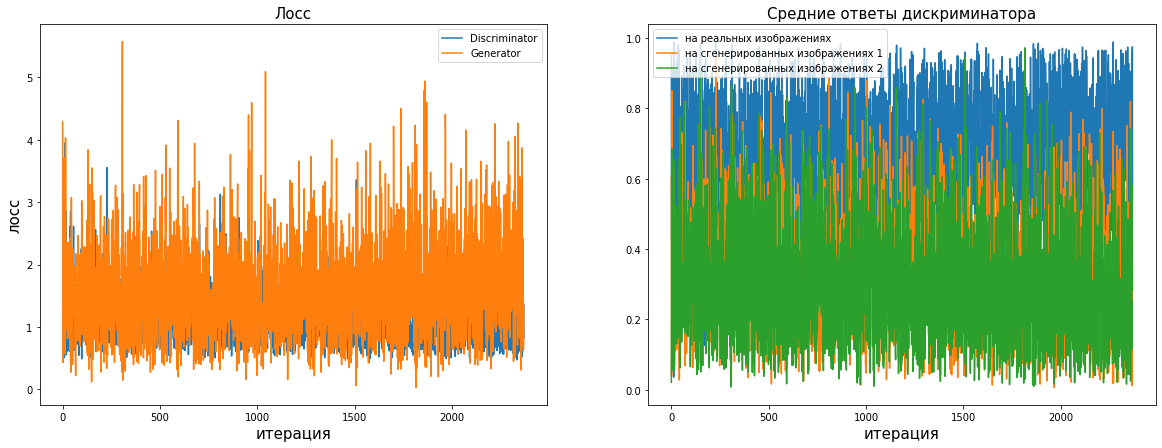

In [ ]:
discr_net, gen_with_attention_net, examples = smart_train_with_augments(
                                     discr_net, 
                                     gen_with_attention_net, 
                                     aug_net,
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


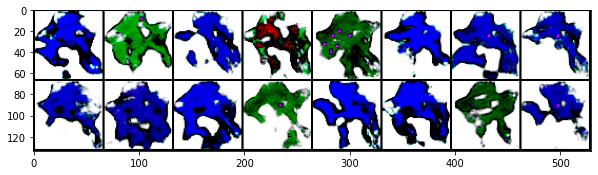

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

### Second model

Augmentations help control the overfitting of the discriminator. Therefore, we can train a more complex model: one with two attention layers in the generator and one in the discriminator.

In [ ]:
class Generator_smart(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        Attention(128),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
class Discriminator_smart(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # 64 x 32 x 32

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 128 x 16 x 16

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 256 x 8 x 8

        Attention(256),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(True),
        # 512 x 4 x 4

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
discr_smart_net = Discriminator_smart().to(device)
gen_smart_net = Generator_smart(100).to(device)
aug_net = Augment(64).to(device)

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_smart_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_smart_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

criterion = functional.binary_cross_entropy
fixed_vectors = torch.randn(16, 100, 1, 1, device=device)

Epoch 60 of 60 took 17.135s


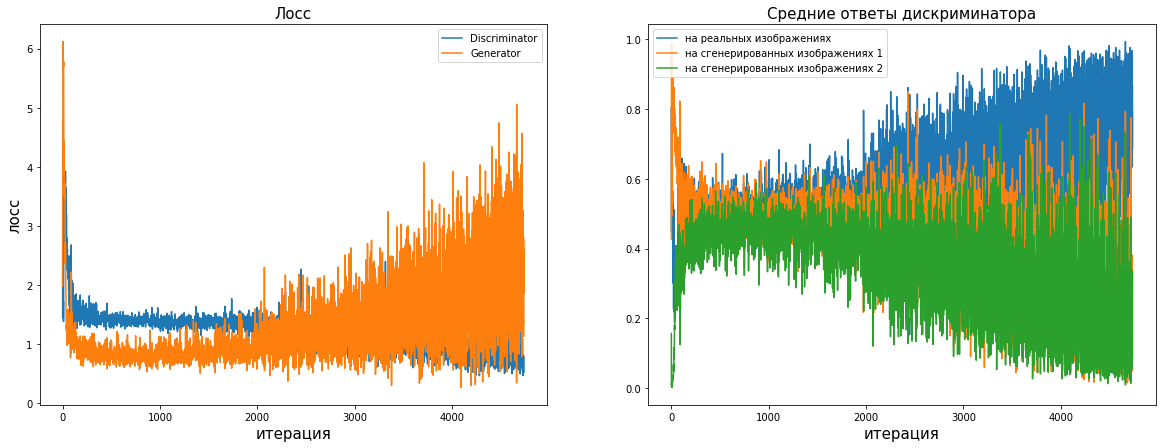

In [ ]:
discr_smart_net, gen_smart_net, examples = smart_train(
                                     discr_smart_net, 
                                     gen_smart_net, 
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 60,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


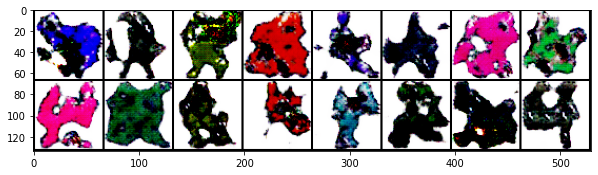

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-1], (1, 2, 0)))

In [ ]:
# torch.save(discr_smart_net.state_dict(), 'discr_smart_net_2')
# torch.save(gen_smart_net.state_dict(), 'gen_smart_net_2')
discr_smart_net.load_state_dict(torch.load('discr_smart_net_2'))
gen_smart_net.load_state_dict(torch.load('gen_smart_net_2'))

discr_lr = 0.0001
gen_lr = 0.003
discr_optim = optim.Adam(discr_smart_net.parameters(), lr=discr_lr, betas=(0.5, 0.9))
gen_optim = optim.Adam(gen_smart_net.parameters(), lr=gen_lr, betas=(0.5, 0.9))

Epoch 30 of 30 took 17.518s


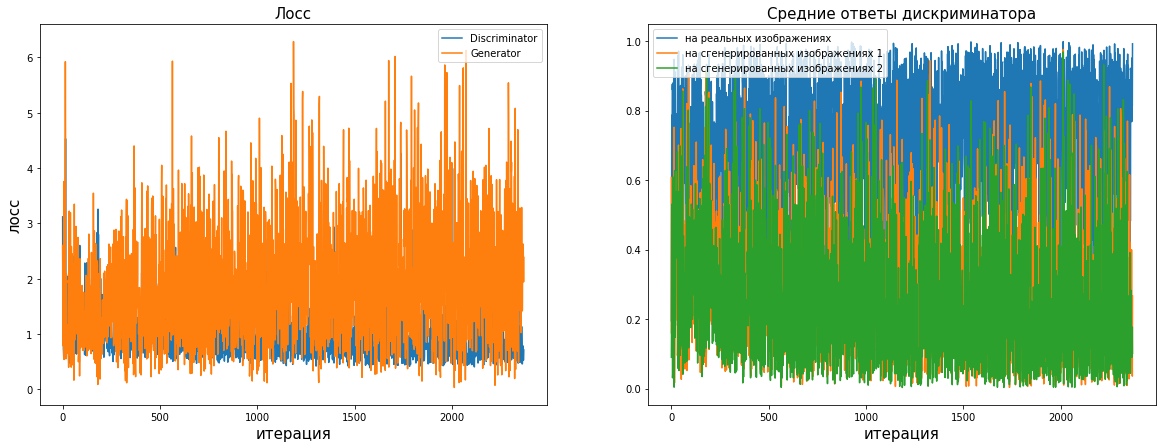

In [ ]:
discr_smart_net, gen_smart_net, examples = smart_train_with_augments(
                                     discr_smart_net, 
                                     gen_smart_net, 
                                     aug_net,
                                     criterion, 
                                     discr_optim, 
                                     gen_optim, dataloader, 30,
                                     fixed_vectors=fixed_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


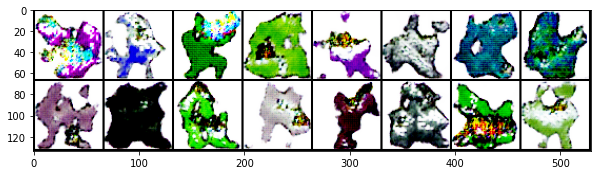

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(examples[-25], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


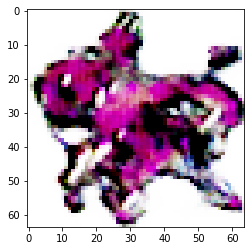

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_smart_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


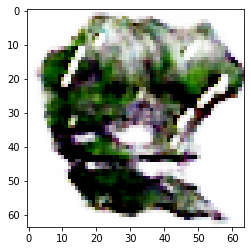

In [ ]:
with torch.no_grad():
  plt.imshow(np.transpose(gen_smart_net(torch.randn(1, 100, 1, 1, device=device)).detach().cpu()[0], (1, 2, 0)))

In [ ]:
torch.save(discr_smart_net.state_dict(), 'discr_smart_net_3')
torch.save(gen_smart_net.state_dict(), 'gen_smart_net_3')

# Load models and results

#### Load models

In [ ]:
class Generator_smart(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        Attention(128),

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

class Attention(nn.Module):
  def __init__(self, D_in):
    super().__init__()

    self.key = nn.Conv2d(D_in, D_in // 4, 1)
    self.query = nn.Conv2d(D_in, D_in // 4, 1)
    self.value = nn.Conv2d(D_in, D_in, 1)
    self.softmax = nn.Softmax(-1)
    
    self.coef = nn.Parameter(torch.zeros(1))

  def forward(self, input):
    size_of_batch, channels, w, h = input.size()

    keys = self.key(input).view(size_of_batch, -1, w * h)
    queries = self.query(input).view(size_of_batch, -1, w * h)
    values = self.value(input).view(size_of_batch, -1, w * h)

    attention = self.softmax(torch.bmm(queries.permute(0, 2, 1), keys))
    output = torch.bmm(values, attention.permute(0, 2, 1))
    output = self.coef * output.view(size_of_batch, channels, w, h) + input

    return output

class Generator_with_attention(nn.Module):
  def __init__(self, input_length):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(input_length, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 32 x 32

        Attention(64),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # 3 x 64 x 64
    )

  def forward(self, input):
    return self.layers(input)

In [ ]:
!wget https://github.com/pollinab/gan_weights/blob/main/gen_smart_net_3?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/gen_with_attention_net_2?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/examples_1?raw=true
!wget https://github.com/pollinab/gan_weights/blob/main/examples_2?raw=true

In [ ]:
gen_with_attention_net = Generator_with_attention(100)
gen_smart_net = Generator_smart(100)

gen_with_attention_net.load_state_dict(torch.load('gen_with_attention_net_2?raw=true', map_location=torch.device('cpu')))
gen_smart_net.load_state_dict(torch.load('gen_smart_net_3?raw=true', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
examples_1 = torch.load('examples_1?raw=true', map_location=torch.device('cpu'))
examples_2 = torch.load('examples_2?raw=true', map_location=torch.device('cpu'))

### Visualize samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

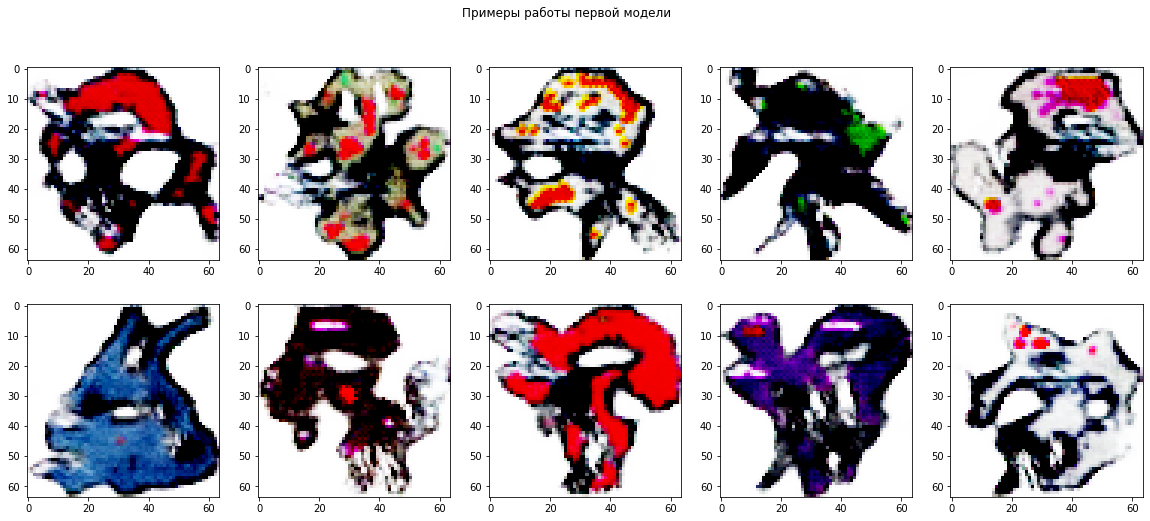

In [ ]:
plt.figure(figsize=(20, 8))

with torch.no_grad():
  for i in range(len(examples_1)):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(gen_with_attention_net(examples_1[i]).detach().cpu()[0], (1, 2, 0)))

plt.suptitle("Примеры работы первой модели") #Samples generated by the first model
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


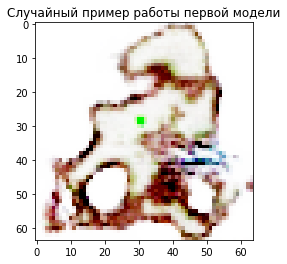

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_with_attention_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

plt.title("Случайный пример работы первой модели")  #Random sample generated by the first model
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

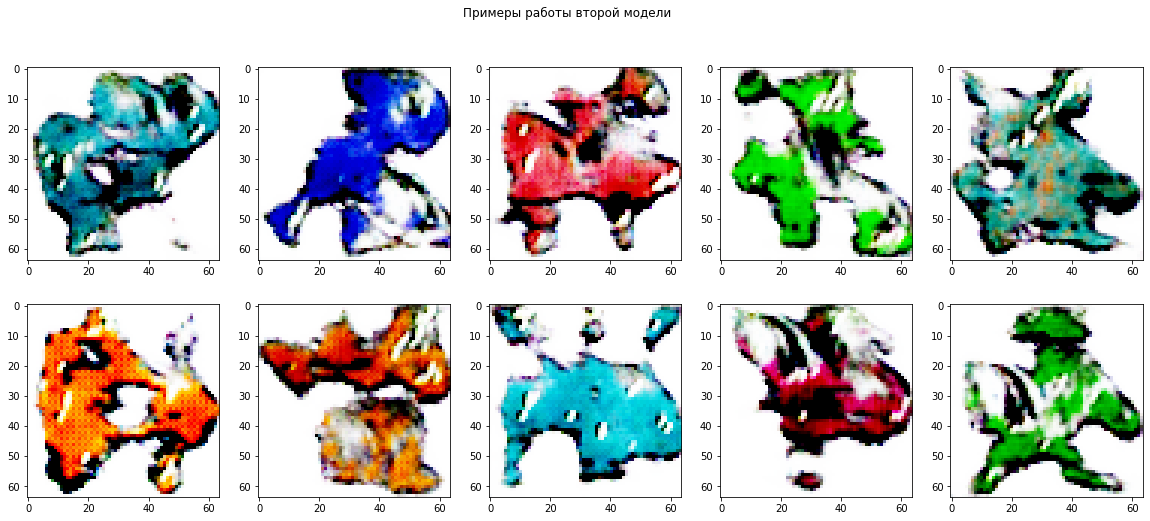

In [ ]:
plt.figure(figsize=(20, 8))

with torch.no_grad():
  for i in range(len(examples_2)):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(gen_smart_net(examples_2[i]).detach().cpu()[0], (1, 2, 0)))

plt.suptitle("Примеры работы второй модели")  #Samples generated by the second model
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


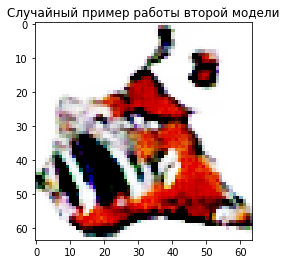

In [ ]:
with torch.no_grad():
  latent_vector = torch.randn(1, 100, 1, 1, device=device)
  plt.imshow(np.transpose(gen_smart_net(latent_vector).detach().cpu()[0], (1, 2, 0)))

plt.title("Случайный пример работы второй модели")  #Random sample generated by the second model
plt.show()